In [2]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 8.7 MB/s eta 0:00:00


训练集: (17999, 29)   真实测试集: (12000, 28)
Train: (12599, 28)   Val: (5400, 28)
After preprocessing - Train: (12599, 43)  Val: (5400, 43)


[I 2025-11-13 20:22:59,261] A new study created in memory with name: no-name-f81299c9-5302-4a19-8823-a5e85ee95d50


选择特征数: 43


[I 2025-11-13 20:23:16,147] Trial 0 finished with value: 0.5830374397720118 and parameters: {'n_estimators': 444, 'learning_rate': 0.010748128556016754, 'max_depth': 9, 'min_child_weight': 6, 'subsample': 0.8277606849887154, 'colsample_bytree': 0.9194922668142651, 'gamma': 0.3495944710376847, 'reg_alpha': 0.13188122009845682, 'reg_lambda': 1.8080450460164073, 'scale_pos_weight': 1.9374786647234905}. Best is trial 0 with value: 0.5830374397720118.
[I 2025-11-13 20:23:27,262] Trial 1 finished with value: 0.5792507405550122 and parameters: {'n_estimators': 429, 'learning_rate': 0.020120682767994384, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.7561090860096227, 'colsample_bytree': 0.8187515624425507, 'gamma': 0.3830262644676678, 'reg_alpha': 0.7676278794448613, 'reg_lambda': 1.1350525691668218, 'scale_pos_weight': 2.9368595095063843}. Best is trial 0 with value: 0.5830374397720118.
[I 2025-11-13 20:23:34,963] Trial 2 finished with value: 0.5738537618832961 and parameters: {'n_est

Optuna 最佳参数: {'n_estimators': 532, 'learning_rate': 0.012581213109720253, 'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.7388063011229176, 'colsample_bytree': 0.8031653352759589, 'gamma': 0.030523908501272137, 'reg_alpha': 0.13483795252001338, 'reg_lambda': 1.7664286646927114, 'scale_pos_weight': 0.8213116949516653}
Optuna 最佳 F1: 0.5999995862235552

====== 阈值选择（基于验证集 PR 曲线）======
最佳阈值: 0.2702
PR 曲线上的最佳 F1: 0.6003

========== 🏋️‍♂️ 训练集表现 ==========
F1-score: 0.6257
ROC-AUC:  0.8675
PR-AUC:   0.6646
混淆矩阵：
 [[7940 1779]
 [ 759 2121]]
Classification report:
               precision    recall  f1-score   support

         0.0       0.91      0.82      0.86      9719
         1.0       0.54      0.74      0.63      2880

    accuracy                           0.80     12599
   macro avg       0.73      0.78      0.74     12599
weighted avg       0.83      0.80      0.81     12599


========== 🧪 验证集表现 ==========
F1-score: 0.6003
ROC-AUC:  0.8382
PR-AUC:   0.6018
混淆矩阵：
 [[3390  775]
 [ 

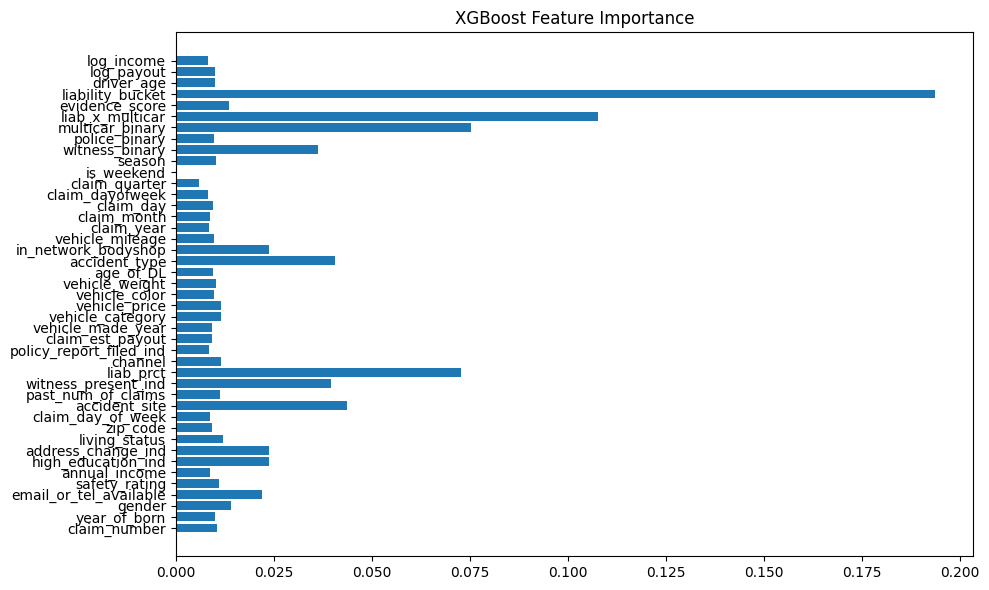

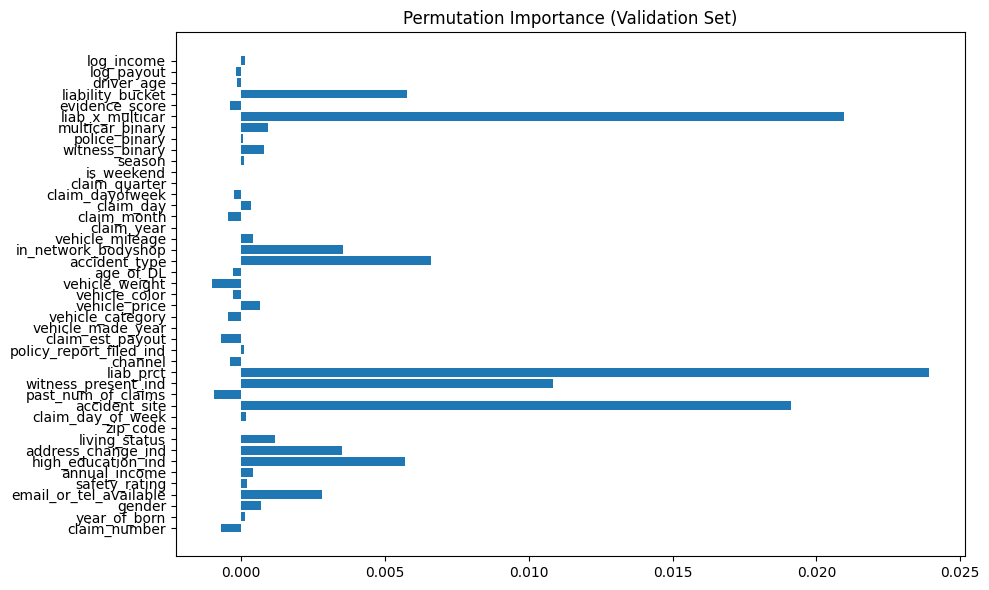

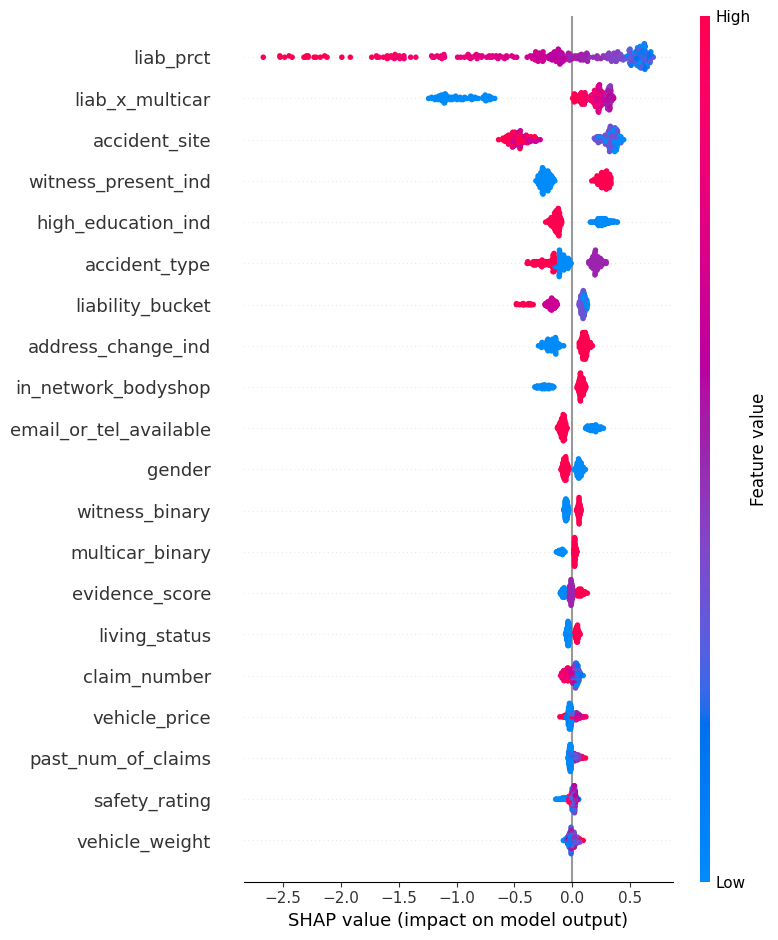


✅ 真实测试集预测完成：/content/drive/MyDrive/TriGuard_14_prediction.csv 已生成


In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    precision_recall_curve, classification_report,
    f1_score, roc_auc_score, average_precision_score,
    confusion_matrix
)
from sklearn.feature_selection import SelectFromModel
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier
import shap
import optuna
import joblib
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# =========================================================
# 1. 加载数据
# =========================================================
df = pd.read_csv("/content/drive/MyDrive/model-citizens/data/Training_TriGuard.csv")
df = df.dropna(subset=['subrogation'])   # 标签不能为空
real_test = pd.read_csv("/content/drive/MyDrive/model-citizens/data/Testing_TriGuard.csv")

print("训练集:", df.shape, "  真实测试集:", real_test.shape)

# =========================================================
# 2. Feature Engineering（已修复 category 问题）
# =========================================================
def enhanced_feature_engineer(df):
    df_fe = df.copy()

    # 时间特征
    df_fe['claim_date'] = pd.to_datetime(df_fe['claim_date'], errors='coerce')
    df_fe['claim_year'] = df_fe['claim_date'].dt.year
    df_fe['claim_month'] = df_fe['claim_date'].dt.month
    df_fe['claim_day'] = df_fe['claim_date'].dt.day
    df_fe['claim_dayofweek'] = df_fe['claim_date'].dt.dayofweek
    df_fe['claim_quarter'] = df_fe['claim_date'].dt.quarter
    df_fe['is_weekend'] = (df_fe['claim_dayofweek'] >= 5).astype(int)

    # Season
    season_map = {
        1:'Winter',2:'Winter',3:'Spring',4:'Spring',5:'Spring',
        6:'Summer',7:'Summer',8:'Summer',9:'Fall',10:'Fall',11:'Fall',12:'Winter'
    }
    df_fe['claim_month'] = df_fe['claim_month'].fillna(1)
    df_fe['season'] = df_fe['claim_month'].map(season_map)

    # Binary features
    df_fe['witness_binary'] = (df_fe['witness_present_ind'] == 'Y').astype(int)
    df_fe['police_binary'] = df_fe['policy_report_filed_ind']
    df_fe['multicar_binary'] = df_fe['accident_type'].isin(
        ['multi_vehicle_clear', 'multi_vehicle_unclear']
    ).astype(int)

    # Interactions / scores
    df_fe['liab_x_multicar'] = df_fe['liab_prct'] * df_fe['multicar_binary']
    df_fe['evidence_score'] = df_fe['witness_binary'] + df_fe['police_binary']

    # Liability buckets（注意是 category 类型）
    bins = [0,10,20,30,40,50,60,70,80,90,100]
    labels = ['0-10','10-20','20-30','30-40','40-50',
              '50-60','60-70','70-80','80-90','90-100']
    df_fe['liability_bucket'] = pd.cut(df_fe['liab_prct'], bins=bins, labels=labels)

    # Driver age
    df_fe['driver_age'] = df_fe['claim_year'] - df_fe['year_of_born']
    df_fe['driver_age'] = df_fe['driver_age'].clip(16, 80)

    # Logs
    df_fe['log_payout'] = np.log1p(df_fe['claim_est_payout'])
    df_fe['log_income'] = np.log1p(df_fe['annual_income'])

    # 删掉原始日期列
    df_fe = df_fe.drop(columns=['claim_date'], errors='ignore')

    # 关键修复：把所有 category 转成 string，方便后续统一用 LabelEncoder
    for col in df_fe.select_dtypes(include=['category']).columns:
        df_fe[col] = df_fe[col].astype(str)

    return df_fe


# =========================================================
# 3. Robust Preprocessor（自动识别所有 object）
# =========================================================
class RobustPreprocessor:
    def __init__(self):
        self.label_encoders = {}
        self.categorical_cols = []
        self.trained_features = None

    def fit(self, df):
        df_fe = enhanced_feature_engineer(df.copy())

        # 自动找出所有 object 类型的列
        self.categorical_cols = df_fe.select_dtypes(include=['object']).columns.tolist()

        # 每个分类变量单独一个 LabelEncoder，并加入 "__UNK__"
        for col in self.categorical_cols:
            le = LabelEncoder()
            vals = df_fe[col].astype(str).fillna("Missing").unique().tolist()
            if "__UNK__" not in vals:
                vals.append("__UNK__")
            le.fit(vals)
            self.label_encoders[col] = le

        # 对训练数据 transform 一次，锁定特征顺序
        df_processed = self._transform_internal(df_fe, is_training=True)
        self.trained_features = df_processed.columns.tolist()
        return self

    def _transform_internal(self, df_fe, is_training=False):
        df_tr = df_fe.copy()

        # 编码分类变量
        for col, le in self.label_encoders.items():
            vals = df_tr[col].astype(str).fillna("Missing")
            known = set(le.classes_)
            vals[~vals.isin(known)] = "__UNK__"
            df_tr[col] = le.transform(vals)

        # 非训练阶段：对齐列（缺的补0，多的丢）
        if not is_training:
            for c in self.trained_features:
                if c not in df_tr.columns:
                    df_tr[c] = 0
            df_tr = df_tr[self.trained_features]

        return df_tr

    def transform(self, df):
        df_fe = enhanced_feature_engineer(df.copy())
        return self._transform_internal(df_fe, is_training=False)


# =========================================================
# 4. Train/Val Split + Feature Selection
# =========================================================
train_df, test_df = train_test_split(
    df, test_size=0.3, random_state=12, stratify=df['subrogation']
)

X_train_raw = train_df.drop(columns=['subrogation'])
y_train = train_df['subrogation']
X_test_raw = test_df.drop(columns=['subrogation'])
y_test = test_df['subrogation']

print("Train:", X_train_raw.shape, "  Val:", X_test_raw.shape)

preprocessor = RobustPreprocessor()
X_train_p = preprocessor.fit(X_train_raw).transform(X_train_raw)
X_test_p = preprocessor.transform(X_test_raw)

print("After preprocessing - Train:", X_train_p.shape, " Val:", X_test_p.shape)

# 初始 XGB 用于特征选择
base_est = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    eval_metric='logloss',
    random_state=12,
    n_jobs=-1
)
base_est.fit(X_train_p, y_train)

sel = SelectFromModel(base_est, prefit=True, max_features=80, threshold=-np.inf)
X_train_sel = sel.transform(X_train_p)
X_test_sel = sel.transform(X_test_p)
selected_features = X_train_p.columns[sel.get_support()]

print("选择特征数:", len(selected_features))


# =========================================================
# 5. Optuna 调参（基于选好特征）
# =========================================================
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 400, 900),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "max_depth": trial.suggest_int("max_depth", 4, 9),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 8),
        "subsample": trial.suggest_float("subsample", 0.7, 0.95),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 0.95),
        "gamma": trial.suggest_float("gamma", 0.0, 0.4),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.5, 2.0),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 0.5, 3.0),
        "eval_metric": "logloss",
        "n_jobs": -1,
        "random_state": 12
    }

    model = XGBClassifier(**params)
    score = cross_val_score(model, X_train_sel, y_train, cv=5, scoring='average_precision').mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=70)

print("Optuna 最佳参数:", study.best_params)
print("Optuna 最佳 F1:", study.best_value)

best_params = study.best_params
best_params.update({"eval_metric": "logloss", "n_jobs": -1})


# =========================================================
# 6. 最终模型 + 阈值搜索
# =========================================================
final_model = XGBClassifier(**best_params)
final_model.fit(X_train_sel, y_train)

# 验证集 PR 曲线
test_proba = final_model.predict_proba(X_test_sel)[:, 1]
prec, rec, th = precision_recall_curve(y_test, test_proba)
f1_curve = 2 * prec * rec / (prec + rec + 1e-6)
best_idx = np.argmax(f1_curve)
best_threshold = th[best_idx]

print("\n====== 阈值选择（基于验证集 PR 曲线）======")
print(f"最佳阈值: {best_threshold:.4f}")
print(f"PR 曲线上的最佳 F1: {f1_curve[best_idx]:.4f}")

# =========================================================
# 6.5 训练集 + 验证集：F1 / ROC-AUC / PR-AUC / 混淆矩阵
# =========================================================
# ---- 训练集 ----
train_proba = final_model.predict_proba(X_train_sel)[:, 1]
train_pred = (train_proba >= best_threshold).astype(int)

train_f1 = f1_score(y_train, train_pred)
train_roc = roc_auc_score(y_train, train_proba)
train_pr = average_precision_score(y_train, train_proba)

print("\n========== 🏋️‍♂️ 训练集表现 ==========")
print(f"F1-score: {train_f1:.4f}")
print(f"ROC-AUC:  {train_roc:.4f}")
print(f"PR-AUC:   {train_pr:.4f}")
print("混淆矩阵：\n", confusion_matrix(y_train, train_pred))
print("Classification report:\n", classification_report(y_train, train_pred))

# ---- 验证集 ----
test_pred = (test_proba >= best_threshold).astype(int)

test_f1 = f1_score(y_test, test_pred)
test_roc = roc_auc_score(y_test, test_proba)
test_pr = average_precision_score(y_test, test_proba)

print("\n========== 🧪 验证集表现 ==========")
print(f"F1-score: {test_f1:.4f}")
print(f"ROC-AUC:  {test_roc:.4f}")
print(f"PR-AUC:   {test_pr:.4f}")
print("混淆矩阵：\n", confusion_matrix(y_test, test_pred))
print("Classification report:\n", classification_report(y_test, test_pred))


# =========================================================
# 7. Feature Importance 可视化
# =========================================================
plt.figure(figsize=(10, 6))
plt.barh(selected_features, final_model.feature_importances_)
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()

# Permutation importance（在验证集上）
perm = permutation_importance(final_model, X_test_sel, y_test, n_repeats=10, random_state=12)
plt.figure(figsize=(10, 6))
plt.barh(selected_features, perm.importances_mean)
plt.title("Permutation Importance (Validation Set)")
plt.tight_layout()
plt.show()


# =========================================================
# 8. SHAP 解释模型
# =========================================================
shap.initjs()
explainer = shap.TreeExplainer(final_model)
# 为了速度，只取前 300 条训练样本
X_shap = pd.DataFrame(X_train_sel, columns=selected_features).iloc[:300]
shap_values = explainer.shap_values(X_shap)

shap.summary_plot(shap_values, X_shap, feature_names=selected_features)




# =========================================================
# 10. 真实测试集预测并保存
# =========================================================
X_real_p = preprocessor.transform(real_test)
X_real_sel = sel.transform(X_real_p)

real_proba = final_model.predict_proba(X_real_sel)[:, 1]
real_pred = (real_proba >= best_threshold).astype(int)

pd.DataFrame({
    "claim_number": real_test["claim_number"],
    "prediction_prob": real_proba,
    "subrogation": real_pred
}).to_csv("/content/drive/MyDrive/TriGuard_14_prediction.csv", index=False)

print("\n✅ 真实测试集预测完成：/content/drive/MyDrive/TriGuard_14_prediction.csv 已生成")


In [8]:
# =========================================================
# 9. 保存 pipeline（可选）
# =========================================================
pipeline_assets = {
    "preprocessor": preprocessor,
    "feature_selector": sel,
    "selected_features": selected_features,
    "model": final_model,
    "threshold": best_threshold
}
joblib.dump(pipeline_assets, "/content/drive/MyDrive/TriGuard_SW14.pkl")
print("\n✅ Pipeline 已保存为 TriGuard_SW14.pkl")



✅ Pipeline 已保存为 TriGuard_SW14.pkl


In [10]:
booster = final_model.get_booster()


booster.save_model("/content/drive/MyDrive/TriGuard_SW14.json")